# Home Credit Default Risk
## Dataset: Home Credit Default Risk
### Source: https://www.kaggle.com/c/home-credit-default-risk/data

### Predict how capable each applicant is of repaying a loan?

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

In [1]:
# Import some libraries needed for analysis
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from datetime import datetime

# Display for notebooks
%matplotlib inline

# 0. Library

In [2]:
def plot_counts(df, feature):
#Plot counts of values in feature in the database df
    palette = sns.color_palette()
    ax = sns.countplot(x=feature, data=df, alpha = 0.8)
    
    n = len(df[feature])
    
    #Make twin axis
    ax1= ax.twinx()
    
    ax.set_ylabel('Count')
    ax1.set_ylabel('%')
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.1f}%'.format(100. * y / n), (x.mean(), y),
                    ha='center', va='bottom')
        
    plt.show()
    
def plot_features_target(df, feature, target, targeted_value):
#Plot counts of values in feature in the database df
#Plot counts of values with target = targeted values
    df_targeted_feature = df[df[target]==targeted_value]
    plot_counts (df_targeted_feature, feature)
    
def category_percentage_by_target(df, feature, target):
    df_percentage = pd.DataFrame(columns = df[target].unique(), index = df[feature].unique())
    for col in df_percentage.columns:
        count = len(df[df[target]==col])
        for row in df_percentage.index:
            df_percentage.at[row, col] = len(df[(df[target]==col) & (df[feature]==row)])*100.0/count
    return df_percentage


## 1. Extract Data

In [3]:
#List all files in data folder
DATA_DIR = 'data'
print(os.listdir(DATA_DIR))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [5]:
#Load the Application Train dataset
df_application_train = pd.read_csv(DATA_DIR + '/application_train.csv')

#Print Application Train dataset info
df_application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## 2. Data Exploration

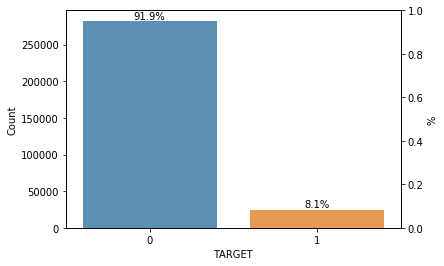

In [6]:
#sns.countplot(x='TARGET', data=df_application_train)
plot_counts(df_application_train, 'TARGET')
plt.show()

Majority of the clients do not have payment difficulties, so the TARGET variable is imbalanced.

In [7]:
# Drop any column that could pose potential discriminatory issues using in a model
# Gender, Family Status, Age, Area of Residence (Redlining), Type of Housing
cols2drop = ['CODE_GENDER', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 
             'DAYS_BIRTH', 'CNT_FAM_MEMBERS', 'REG_REGION_NOT_LIVE_REGION', 
             'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
             'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
             'LIVE_CITY_NOT_WORK_CITY', 'REGION_POPULATION_RELATIVE', 
             'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY','APARTMENTS_AVG',
             'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 
             'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
             'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
             'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 
             'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE', 
             'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
             'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 
             'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 
             'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 
             'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
             'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 
             'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 
             'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
             'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
             # Columns to drop based on intuition
             'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 
             'FLAG_MOBIL', 'FLAG_EMP_PHONE' , 'FLAG_WORK_PHONE' ,'FLAG_CONT_MOBILE', 
             'FLAG_PHONE', 'FLAG_EMAIL', 'OWN_CAR_AGE',
             ]
df_application_train = df_application_train.drop(columns = cols2drop, axis = 1)

# Display top n records
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,N,Y,202500.0,406597.5,24700.5,351000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,N,N,270000.0,1293502.5,35698.5,1129500.0,State servant,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,Y,Y,67500.0,135000.0,6750.0,135000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,N,Y,135000.0,312682.5,29686.5,297000.0,Working,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,N,Y,121500.0,513000.0,21865.5,513000.0,Working,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Review Categorical variables
df_application_train.describe(include='O')

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
count,307511,307511,307511,307511,307511,307511,211120,307511
unique,2,2,2,8,5,6,18,58
top,Cash loans,N,Y,Working,Secondary / secondary special,House / apartment,Laborers,Business Entity Type 3
freq,278232,202924,213312,158774,218391,272868,55186,67992


There are 8 categorical variables. We will look at distribution of TARGET based on categorial values.

In [9]:
categorical_features = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE']
for f in categorical_features:
    df_percentage = category_percentage_by_target(df_application_train, f, 'TARGET')
    print(df_percentage)
#df_percentage = category_percentage_by_target(df_application_train, 'NAME_CONTRACT_TYPE', 'TARGET')
#sns.countplot(x='TARGET', hue='NAME_CONTRACT_TYPE', data=df_application_train)
#sns.barplot(y=df_percentage.columns, x=df_percentage.index)
#print(df_percentage[1])

                       1        0
Cash loans       93.5388    90.21
Revolving loans  6.46123  9.79001
         1        0
N  69.4824  65.6824
Y  30.5176  34.3176
         1        0
Y  68.4109  69.4513
N  31.5891  30.5487
                               1           0
Working                  61.3253     50.7807
State servant            5.03122     7.23559
Commercial associate     21.5911     23.4384
Pensioner                12.0121     18.5294
Unemployed             0.0322256  0.00495249
Student                        0  0.00636749
Businessman                    0  0.00353749
Maternity leave       0.00805639  0.00106125
                                       1          0
Secondary / secondary special    78.6465    70.3491
Higher education                  16.149    25.0646
Incomplete higher                3.51259    3.32701
Lower secondary                  1.67976    1.20239
Academic degree                0.0120846  0.0569537
                           1         0
House / apartment    8

#### Look at distribution of numerical variables vs TARGET

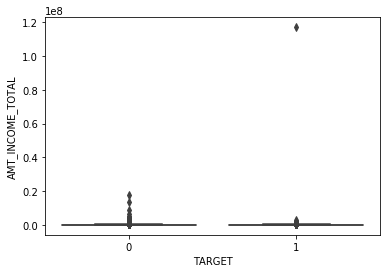

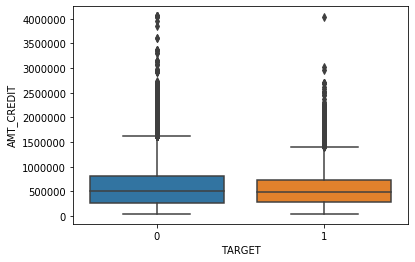

In [13]:
sns.boxplot(y='AMT_INCOME_TOTAL', x='TARGET', data=df_application_train)
plt.show()
sns.boxplot(y='AMT_CREDIT', x='TARGET', data=df_application_train)
plt.show()